In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from preprocessing import preprocess_data

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../data/Spotify_train_dataset.csv')

df_compet = pd.read_csv('../data/Spotify_test_dataset.csv')

print(df_compet.shape)

features_columns = ['danceability', 'energy', 'key', 'loudness', 'mode',
        'speechiness', 'acousticness', 'instrumentalness', 'liveness',
        'valence', 'tempo', 'duration_ms', 'time_signature']

label = 'genre'

(10577, 19)


In [3]:
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
df_label_encoded = le.fit_transform(df[label])

df_standardized = preprocess_data(df, features_columns, standardize=True)
print(f"Shape dataframe original standardized without outliers :{df_standardized.shape}")

df_compet_standardized = preprocess_data(df_compet, features_columns, standardize=True)
print(f"Shape dataframe original standardized without outliers :{df_compet_standardized.shape}")

------------------------------------------
            Preprocessing data            
------------------------------------------
Get dataset
Shape of the data to process : (31728, 20)
------------------------------------------
Extract inputs ...
Center and reduce inputs ...
------------------------------------------
Data shape after preprocessing : (31728, 13)
Return dataset(s) ...
Preprocessing finished
------------------------------------------
Shape dataframe original standardized without outliers :(31728, 13)
------------------------------------------
            Preprocessing data            
------------------------------------------
Get dataset
Shape of the data to process : (10577, 19)
------------------------------------------
Extract inputs ...
Center and reduce inputs ...
------------------------------------------
Data shape after preprocessing : (10577, 13)
Return dataset(s) ...
Preprocessing finished
------------------------------------------
Shape dataframe original stand

In [4]:
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

def compute_score_depth(X, y, depth_list):
    scores = np.zeros(shape=len(depth_list))
    kfold = KFold(n_splits=10, random_state=5)

    for i, depth in enumerate(depth_list):

        tree = RandomForestClassifier(max_depth=depth, random_state=5)
        y_pred = cross_val_predict(tree, X, y, cv=kfold)

        recall = recall_score(y, y_pred, average='micro')
        precision = precision_score(y, y_pred, average='micro')

        f_score = 2 * (precision * recall) / (precision + recall)

        scores[i] = f_score

    return scores

def make_classification_report(X, y, class_names, clf):
    kfold = KFold(n_splits=10, random_state=5)
    y_pred = cross_val_predict(clf, X, y, cv=kfold)
    cf_matrix = confusion_matrix(y, y_pred)

    fig, ax = plt.subplots(figsize=(15,15))

    sns.heatmap(cf_matrix, annot=True, ax=ax, cmap='hot_r')
    plt.show()

    return classification_report(y, y_pred, target_names=class_names)

def plot_scores_vs_depth(depth_list, score_list, title):
    plt.plot(depth_list, score_list, label='F1-Score vs depth')
    plt.xlabel('Depth')
    plt.suptitle(title)
    plt.grid()
    plt.show()


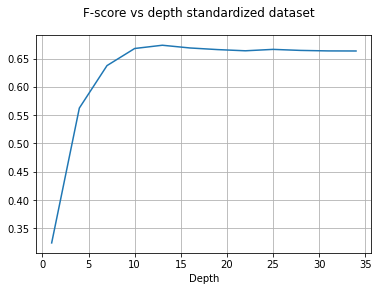

In [5]:
depth_list = [x for x in range(1, 35, 3)]
score_standardized= compute_score_depth(df_standardized, df_label_encoded, depth_list)
plot_scores_vs_depth(depth_list, score_standardized, 'F-score vs depth standardized dataset')

In [6]:
kfold = KFold(n_splits=10, random_state=5)

optimal_depth = depth_list[np.argmax(score_standardized)]
benchmark = RandomForestClassifier(max_depth=optimal_depth, random_state=5, n_estimators=200)
y_pred = cross_val_predict(benchmark, df_standardized, df_label_encoded, cv=kfold)

recall = recall_score(df_label_encoded, y_pred, average='micro')
precision = precision_score(df_label_encoded, y_pred, average='micro')

f_score = 2 * (precision * recall) / (precision + recall)

print(f"recall : {recall}\nprecision : {precision}\nScore : {f_score}")

recall : 0.6754916792738276
precision : 0.6754916792738276
Score : 0.6754916792738276


# Prediction

In [8]:
final_clf = RandomForestClassifier(max_depth=optimal_depth, random_state=5, n_estimators=200)
final_clf.fit(df_standardized, df_label_encoded)

prediction = final_clf.predict(df_compet_standardized)
prediction_labels = le.inverse_transform(prediction)

In [12]:
df_prediction_labels = pd.DataFrame({'genres' : prediction_labels})
df_prediction_labels.to_csv('Les Wigolos (gold) prediction.csv')
